In [1]:
import pandas as pd
df = pd.read_pickle("./mobileCarriers.pkl")
df.shape

(213859, 4)

In [2]:
df.head(1)

,screen_name,date_time,location,text
0,leila_fong,2019-10-23 23:57:59,"Illinois, USA","@ATTHelp I’m blocking, but then they change th..."


In [25]:
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from textblob import TextBlob
import time 
from bs4 import BeautifulSoup
import requests

tokenizer = TweetTokenizer()

In [26]:
df.text[0]

'@ATTHelp I’m blocking, but then they change the number by one digit and then switch to “unknown”.'

In [29]:
clf_text = []
carrier = []
polarity = [0.0]*len(df)
subjectivity = [0.5]*len(df)
sentiment = [""]*len(df)
stop_label = ["&amp;", "&gt;", "&lt;"]

att_lis = ['ATT','ATTHelp']
ver_lis = ['VerizonSupport','verizon','VZWSupport']
tmo_lis = ['TMobile','TMobileHelp']
start_time = time.time()
for i in df.index:
    # tokenized_tweets
    tweet = tokenizer.tokenize(df.text[i])
    # fetch the full tweet text based on the link provided at the last of the truncated tweet
#     if len(tweet[-1]) == 23:
#         # if truncated tweet, fetch the full text
#         try:
#             html=requests.get(tweet[-1]).text
#             soup=BeautifulSoup(html,'html.parser')
#             title = soup.find_all('title')
#             full_text = title[0].string.split('on Twitter: "')[1]
#             tweet = tokenizer.tokenize(full_text)
#         except Exception as e:
#             print(i, e)
    # clean corpus for classification
    tlinks = [w for w in tweet if re.search("^https:\w+", w)]
    words = [w.lower() for w in tweet if w not in tlinks and w not in stop_label]
    words = [w for w in words if w.isalpha() or 'att' in w or 'verizon' in w or 'tmobile' in w]
    clf_text.append(' '.join(words))
    
    # carrier
    screen_name = df.screen_name[i]
    current_carrier = []
    if 'att' in words or '@att' in words or '@atthelp' in words or screen_name in att_lis:
        current_carrier.append('att')
    if 'verizon' in words or '@verizon' in words or '@verizonsupport' in words or '@vzwsupport' in words or screen_name in ver_lis:
        current_carrier.append('verizon')
    if 'tmobile' in words or '@tmobile' in words or '@tmobilehelp' in words or screen_name in tmo_lis:
        current_carrier.append('tmobile')
    carrier.append(' '.join(current_carrier))

    # Sentiment
    blob = TextBlob(df.text[i])
    polarity[i] = blob.polarity
    subjectivity[i] = blob.subjectivity
    if polarity[i] > 0.0:
        sentiment[i] = "pos"
    elif polarity[i] < 0.0:
        sentiment[i] = "neg"
    else:
        sentiment[i] = "neu"
        
print('Elapsed clock time: ', (time.time() - start_time), ' seconds')

Elapsed clock time:  141.04312300682068  seconds


In [33]:
df["clf_text"] = clf_text
df["carrier"] = carrier
df["sentiment"] = sentiment
df["polarity"] = polarity
df["subjectivity"] = subjectivity

In [34]:
df.carrier.value_counts(), len(df)

(att                    71816
 verizon                52901
                        51300
 tmobile                31336
 att tmobile             2420
 verizon tmobile         2046
 att verizon             1392
 att verizon tmobile      648
 Name: carrier, dtype: int64, 213859)

In [35]:
# drop duplicates records

uniqueDF = df.drop_duplicates(['clf_text'],keep='first',inplace=False)

In [36]:
uniqueDF = uniqueDF[uniqueDF.carrier != '']
len(uniqueDF)

97174

In [37]:
uniqueDF.clf_text.value_counts()
uniqueDF.carrier.value_counts()

att                    36374
verizon                35730
tmobile                22659
verizon tmobile          765
att tmobile              739
att verizon              712
att verizon tmobile      195
Name: carrier, dtype: int64

### Read clf_text

In [44]:
uniqueDF["clf_text"].head()

0    @atthelp i m blocking but then they change the...
1    @atthelp just logged into my account and it s ...
2    @atthelp can t get my visual voicemail to work...
3    @atthelp you were charging me for an outdated ...
4    hey leila here to help click here to learn how...
Name: clf_text, dtype: object

In [45]:
uniqueDF["text"].head()

0    @ATTHelp I’m blocking, but then they change th...
1    @ATTHelp Just logged into my account and it’s ...
2    @ATTHelp can’t get my Visual Voicemail to work...
3    @ATTHelp You were charging me $150 for an outd...
4    @leila_fong Hey, Leila, we're here to help. Cl...
Name: text, dtype: object

In [49]:
att_df = uniqueDF[uniqueDF['carrier']=='att'][['carrier','sentiment','polarity','text','clf_text']]
ver_df = uniqueDF[uniqueDF['carrier']=='verizon'][['carrier','sentiment','polarity','text','clf_text']]
tmo_df = uniqueDF[uniqueDF['carrier']=='tmobile'][['carrier','sentiment','polarity','text','clf_text']]

tmo_att_df = uniqueDF[uniqueDF['carrier']=='att tmobile'][['carrier','sentiment','polarity','text','clf_text']]
att_ver_df = uniqueDF[uniqueDF['carrier']=='att verizon'][['carrier','sentiment','polarity','text','clf_text']]
tmo_ver_df = uniqueDF[uniqueDF['carrier']=='verizon tmobile'][['carrier','sentiment','polarity','text','clf_text']]

tmo_att_ver_df = uniqueDF[uniqueDF['carrier']=='att verizon tmobile'][['carrier','sentiment','polarity','text','clf_text']]

In [50]:
# only_att_pos = att_df[att_df['sentiment']=='pos'].sample(25)
# only_att_neg = att_df[att_df['sentiment']=='neg'].sample(25)
# only_ver_pos = ver_df[ver_df['sentiment']=='pos'].sample(25)
# only_ver_neg = ver_df[ver_df['sentiment']=='neg'].sample(25)
# only_tmo_pos = tmo_df[tmo_df['sentiment']=='pos'].sample(25)
# only_tmo_neg = tmo_df[tmo_df['sentiment']=='neg'].sample(25)

# tmo_att = tmo_att_df.sample(50)
# att_ver = att_ver_df.sample(50)
# tmo_ver = tmo_ver_df.sample(50)

# tmo_att_ver = tmo_att_ver_df.sample(50)


# clf_corpus = pd.concat([only_att_pos,only_att_neg,only_ver_pos,only_ver_neg,only_tmo_pos,only_tmo_neg,tmo_att,att_ver,tmo_ver,tmo_att_ver] ,ignore_index=False)
# clf_corpus.to_csv('clf_corpus1.csv')

In [52]:
only_att_pos = att_df[att_df['sentiment']=='pos'][:25]
only_att_neg = att_df[att_df['sentiment']=='neg'][:25]
only_ver_pos = ver_df[ver_df['sentiment']=='pos'][:25]
only_ver_neg = ver_df[ver_df['sentiment']=='neg'][:25]
only_tmo_pos = tmo_df[tmo_df['sentiment']=='pos'][:25]
only_tmo_neg = tmo_df[tmo_df['sentiment']=='neg'][:25]

tmo_att = tmo_att_df[25:50]
att_ver = att_ver_df[25:50]
tmo_ver = tmo_ver_df[25:50]

tmo_att_ver = tmo_att_ver_df[25:50]


clf_corpus = pd.concat([only_att_pos,only_att_neg,only_ver_pos,only_ver_neg,only_tmo_pos,only_tmo_neg,tmo_att,att_ver,tmo_ver,tmo_att_ver] ,ignore_index=False)

In [134]:
tmo_att = tmo_att_df[75:200]
att_ver = att_ver_df[75:200]
tmo_ver = tmo_ver_df[75:200]

tmo_att_ver = tmo_att_ver_df[75:200]

clf_corpus = pd.concat([tmo_att,att_ver,tmo_ver,tmo_att_ver] ,ignore_index=False)

In [135]:
# tmo_att.head()
tmo_att.iloc[0].text

'@JohnLegere @ATT @TMobile Maybe PR should piss or get off the pot !  Become a State or just exist as a 3rd world Carib Island.'

In [136]:
clf_corpus.head()

,carrier,sentiment,polarity,text,clf_text
27290,att tmobile,neu,0.000000,@JohnLegere @ATT @TMobile Maybe PR should piss...,@att @tmobile maybe pr should piss or get off ...
27299,att tmobile,neg,-0.354545,@JohnLegere @ATT @TMobile Anybody give a shit ...,@att @tmobile anybody give a shit about the ne...
27364,att tmobile,neu,0.000000,@ATT @Prettyymichee @SamirGotti @TMobile would...,@att @tmobile would never
27461,att tmobile,neg,-0.054545,"Love @TMobile services, T-Mobile Tuesday and c...",love @tmobile services tuesday and cheaper pla...
28139,att tmobile,neu,0.000000,@essayareayaitch Iswitched from ATT to @TMobil...,iswitched from att to @tmobile at chi marathon...


In [137]:
# clf_corpus
# get the full text
clf_text = []
full_text = []
stop_label = ["&amp;", "&gt;", "&lt;"]

start_time = time.time()
for i in range(len(clf_corpus)):
    # tokenized_tweets
    text = clf_corpus.iloc[i].text
    tweet = tokenizer.tokenize(text)
    if len(tweet[-1]) == 23:
        # if truncated tweet, fetch the full text based on the link
        try:
            html=requests.get(tweet[-1]).text
            soup=BeautifulSoup(html,'html.parser')
            title = soup.find_all('title')
            text = title[0].string.split('on Twitter: "')[1]
            tweet = tokenizer.tokenize(text)
        except Exception as e:
            print(e, i, text)
    full_text.append(text)
    
    # clean corpus for classification
    tlinks = [w for w in tweet if re.search("^https:\w+", w)]
    words = [w.lower() for w in tweet if w not in tlinks and w not in stop_label]
    words = [w for w in words if w.isalpha() or 'att' in w or 'verizon' in w or 'tmobile' in w]
    clf_text.append(' '.join(words))

clf_corpus["clf_text"] = clf_text
clf_corpus["text"] = full_text

list index out of range 3 Love @TMobile services, T-Mobile Tuesday and cheaper  plan compare to @ATT .  But hate the new iPhone promotions on… https://t.co/rEmCuNFz06
list index out of range 52 @ATTHelp @kellylintz It was SUPPOSED to be low cost because we were ATT cell subscribers. TMobile subs got Hulu and… https://t.co/A9XtSa7qkW
list index out of range 74 @JohnLegere @ATT @TMobile Sorry John, you’re money is wasted with @jack on @Twitter  I have to block this promoted… https://t.co/RT9Enh0FtJ
list index out of range 95 @JasonBoydWrites @VZWSupport @ATT @TMobile I’m literally at work and had to shut my office door bc I almost screame… https://t.co/khzwEunGaY
list index out of range 96 @JasonBoydWrites @VZWSupport @ATT @TMobile Yup. It’s their indifference on the phone. The financial services ppl ar… https://t.co/rHD15MPrfW
list index out of range 99 @JasonBoydWrites @VZWSupport @ATT @TMobile Serious? I’m gonna look into their plans. Question. What made you switch… https://t.co/Ku6e7

In [138]:
clf_corpus.head()

,carrier,sentiment,polarity,text,clf_text
27290,att tmobile,neu,0.000000,@JohnLegere @ATT @TMobile Maybe PR should piss...,@att @tmobile maybe pr should piss or get off ...
27299,att tmobile,neg,-0.354545,@JohnLegere @ATT @TMobile Anybody give a shit ...,@att @tmobile anybody give a shit about the ne...
27364,att tmobile,neu,0.000000,@ATT @Prettyymichee @SamirGotti @TMobile would...,@att @tmobile would never
27461,att tmobile,neg,-0.054545,"Love @TMobile services, T-Mobile Tuesday and c...",love @tmobile services tuesday and cheaper pla...
28139,att tmobile,neu,0.000000,Iswitched from ATT to @TMobile at Chi Marathon...,iswitched from att to @tmobile at chi marathon...


In [139]:
clf_corpus.to_csv('new_clf_corpus4.csv')

## Rule-based  Feature Engineering

In [21]:
tweets_doc =[
"@ATT @TMobile Fix your service in Queens, NY. It’s awful.",
"She asked me what service I had, and I told her @ATT. She told me that @tmobile was way better and that they had better service in my area 😂😂😂. She went on to tell me that they had true unlimited and that AT&T did not.",
"@ATT @TMobile What about the VI tho? all cover that or we gotta switch to @sprint",
"Being a @ATT customer for 10 years and switch to @tmobilepr back in DEC was a bad decision.",
"@ATT  Dude gotta try TMobile. @TMobileHelp and the Chicago team of experts are amazing. The team of experts anywhere!! And oddly Google too I had a good experience.",
"The grass isn’t always greener...I miss you @tmobile. Can I come home? I hate it here @att",
"@ATTHelp @ATT Can you transfer my old tmobile prepaid number to my new phone with AT&amp;T?",
"@TMobile you have referral program? I'm making it my mission to free people from @ATT and bring them to @JohnLegere and his team!!!",
"@TMobile @ATT And we Like @tmobilepr",
"@ATT @TMobile @ATT stinks!"
"@ATT Come to T Mobile. @TMobile",
"@TMobile @verizon @sprint Do you suspend your long-standing customers account when they raise an inquiry about strange chargers on their account? Did that with @ATTHelp and they suspend my act instead of looking into my inquiry. Been a month now. How do I switch?",
"What‚Äôs does @TMobile bring me for Christmas @verizon is giving out Disney+ https://t.co/McMRZJ6LOl",
"Thinking about switching from @ATT to @sprint or at @TMobile. This decision is harder than I thought lol"]

In [4]:
tweet = tweets_doc[0]
tweet

'@ATT @TMobile Fix your service in Queens, NY. It’s awful.'

In [5]:
from textblob import TextBlob

In [7]:
TextBlob(tweet).sentiment

Sentiment(polarity=-1.0, subjectivity=1.0)

In [11]:
tweet_blob = TextBlob(tweet)
tweet_blob.tags

[('@', 'JJ'),
 ('ATT', 'NNP'),
 ('@', 'NNP'),
 ('TMobile', 'NNP'),
 ('Fix', 'NNP'),
 ('your', 'PRP$'),
 ('service', 'NN'),
 ('in', 'IN'),
 ('Queens', 'NNP'),
 ('NY', 'NNP'),
 ('It', 'PRP'),
 ('’', 'VBZ'),
 ('s', 'JJ'),
 ('awful', 'NN')]

In [13]:
tweet_blob.noun_phrases

WordList(['att', 'tmobile fix', 'queens', 'ny', '’ s awful'])

In [14]:
tweet_blob.words

WordList(['ATT', 'TMobile', 'Fix', 'your', 'service', 'in', 'Queens', 'NY', 'It', '’', 's', 'awful'])

In [18]:
tweet_blob.sentences[0].string
tweet_blob.sentences

[Sentence("@ATT @TMobile Fix your service in Queens, NY."),
 Sentence("It’s awful.")]

In [19]:
tweet

'@ATT @TMobile Fix your service in Queens, NY. It’s awful.'

In [21]:
' '.join(tweet_blob.words)

'ATT TMobile Fix your service in Queens NY It ’ s awful'

In [965]:
# TextBlob(tweet.lower()).tags

In [38]:
TextBlob(tweet_blob.sentences[0].string).sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

### Rule-based Algorithm

In [120]:
from textblob import TextBlob
import re

def getSubject(text):
#     carrier = ['ATT', 'Verizon', 'TMobile']
    # get the Subject of text
    subject = []
    if re.search(r'\b[Aa][Tt][Tt]\S*', text):
        subject.append('ATT')
    if re.search(r'\b[Vv][Ee][Rr][Ii][Zz][Oo][Nn]\S*', text):
        subject.append('Verizon')
    if re.search(r'\b[Tt][Mm][Oo][Bb][Ii][Ll][Ee]\S*', text):
        subject.append('TMobile')
    return subject


def getReason(text):
    # get the reason of text
    indicator = ['service','better','experts','disney','network','wifi','price','tower','coverage','family']
        # Suggestion1: focus on Comparative adj with tagging
    # Reason
    reason = []
    sentences = TextBlob(text).sentences
    for s in sentences:
        for i in indicator:
            if s not in reason and i in s.lower():
                reason.append(s.string)
    return reason


def getChurnCarrier(text):
    text = text.replace('&amp;', '')
    text = text.replace('T Mobile', 'tmobile')
    text = text.replace('and', '.')
    text = text.replace(',', '.')
    pol = {'other':0}
    subjects = getSubject(text)
    sentences = TextBlob(text).sentences
    for s in sentences:
        s = s.string
        # clean the sentense
        s = re.sub(r'@[Tt][Mm][Oo][Bb][Ii][Ll][Ee]\S*', "tmobile", s)
        s = re.sub(r'@JohnLegere\S*', "tmobile", s)
        s = re.sub(r'@[Aa][Tt][Tt]\S*', "att", s)
        s = re.sub(r'@[Vv][Ee][Rr][Ii][Zz][Oo][Nn]\S*', "verizon", s)
        tokens = TextBlob(s.lower()).words

        # special rules
        # Special Rule 1: switch to...
        swObj = re.search(r'\bswitch\S*', s, re.I)
        trObj = re.search(r'\btransfer\S*', s, re.I)
        frObj = re.search(r'\bfree\S*', s, re.I)
        coObj = re.search(r'\bcome\S*', s, re.I)
        if swObj!=None or trObj!=None or frObj!=None or coObj!=None:
            v = 0
            counts = 0
            for w in tokens:
                if w == 'from': v = -0.8; continue
                elif w == 'to': v = 0.8; continue
                for sub in subjects:
                    if sub.lower() == w:
                        pol[sub.lower()] = pol.get(sub.lower(), 0) + v
                        if v == 0.8:
                            counts += 1
            if counts == 0:
                # when switch to a carrier not belong to the Three
                for sub in subjects:
                    pol[sub.lower()] = pol.get(sub.lower(), 0) - 0.5
            # print(s, '\nfrom to: ', pol)

        # Special Rule 2: Like (Object)
        lkObj = re.search(r'\blike\S*', s, re.I)
        if lkObj:
            v = 0
            for w in tokens:
                if w == 'like': v = 0.5; continue
                for sub in subjects:
                    if sub.lower() == w:
                        pol[sub.lower()] = pol.get(sub.lower(), 0) + v
            # print('like', pol)

        # Special Rule 3: Disney and Verizon  
        veObj = re.search(r'\bverizon\S*', s, re.I)
        dyObj = re.search(r'\bdisney\S*', s, re.I)
        if veObj!=None and dyObj!=None:
            pol['verizon'] = pol.get('verizon', 0) + 0.5

        # sentiment analysis for segament carrier sentence
        contain = 0
        for sub in subjects:
            if sub.lower() in tokens:
                count = TextBlob(s).words.count(sub.lower())
                pol[sub.lower()] = pol.get(sub.lower(), 0) + count*TextBlob(s).polarity
                contain += 1
        if contain==0:
            pol['other'] += TextBlob(s).polarity
        # print(s, '\nsentiment: ', pol)

    # update the sentiment polarity of each carrier
    for k,v in pol.items():
        if k != 'other':
            pol[k] += pol['other']
    # print('original: ', pol)

    # sort the carrier by the score
    scores = []
    del pol['other']
    for k,v in pol.items():
        scores.append((v,k))
    scores.sort(reverse=True)
    print('scores: ', pol)

    # identify how user churn from one carrier to another
    from_carrier = []
    to_carrier = []
    if len(scores)>0:
        if scores[0][0] < 0:  # (-1, -2, -3)
            for s in scores:
                from_carrier.append(s[1])
        elif scores[0][0] > 0:  # (2, 1, 0)
            to_carrier.append(scores[0][1])
            for i in range(1,len(scores)):
                from_carrier.append(scores[i][1])
        else:  # (0, 0, 0); (0, -1, -2)/(0, 0, -1); 
            # Highest score is 0
            score,_ = zip(*scores)
            if sum(score) == 0:
                for s in scores:
                    from_carrier.append(s[1])
            else:
                for s in scores:
                    if s[0] == 0:
                        to_carrier.append(s[1])
                    else:
                        from_carrier.append(s[1])

    # print('Conclusion: Churn from ', from_carrier, ' to ',  to_carrier)
    return from_carrier,to_carrier


def getChurnAndReason(text):
    subject = getSubject(text)
    reason = getReason(text)
    from_carrier,to_carrier = getChurnCarrier(text)
    print("Subjects:", subject)
    print("Reason:", reason)
    print('Conclusion: Churn from ', from_carrier, ' to ',  to_carrier)
    return from_carrier,to_carrier,reason
    # improve the reason algorithm: only pick out clause not sentense

## 1st tweet -- done -- A (Suggestions), (Comments)

In [105]:
tweets_doc[0]

'@ATT @TMobile Fix your service in Queens, NY. It’s awful.'

In [106]:
getChurnAndReason(tweets_doc[0])

sorted:  {'att': -1.0, 'tmobile': -1.0}
Subjects: ['ATT', 'TMobile']
Reason: ['@ATT @TMobile Fix your service in Queens, NY.']
Conclusion: Churn from  ['tmobile', 'att']  to  []


(['tmobile', 'att'], [], ['@ATT @TMobile Fix your service in Queens, NY.'])

## 2nd tweet -- done -- A is better (comparative adj.)

In [107]:
tweet2 = tweets_doc[1]; print(tweet2)

She asked me what service I had, and I told her @ATT. She told me that @tmobile was way better and that they had better service in my area 😂😂😂. She went on to tell me that they had true unlimited and that AT&T did not.


In [108]:
getChurnAndReason(tweet2) # improve the reason algorithm,

sorted:  {'att': 0.85, 'tmobile': 1.35}
Subjects: ['ATT', 'TMobile']
Reason: ['She asked me what service I had, and I told her @ATT.', 'She told me that @tmobile was way better and that they had better service in my area 😂😂😂.']
Conclusion: Churn from  ['att']  to  ['tmobile']


(['att'],
 ['tmobile'],
 ['She asked me what service I had, and I told her @ATT.',
  'She told me that @tmobile was way better and that they had better service in my area 😂😂😂.'])

## 3rd tweet -- done -- Switch to A

In [110]:
tweet3 = tweets_doc[2]; print(tweet3)

@ATT @TMobile What about the VI tho? all cover that or we gotta switch to @sprint


In [111]:
getChurnAndReason(tweet3) # improve the reason algorithm

sorted:  {'att': -0.5, 'tmobile': -0.5}
Subjects: ['ATT', 'TMobile']
Reason: []
Conclusion: Churn from  ['tmobile', 'att']  to  []


(['tmobile', 'att'], [], [])

## 4th tweet -- Unsolved -- Switch to A is a bad decision

In [1063]:
tweet4 = tweets_doc[3]; print(tweet4)

Being a @ATT customer for 10 years and switch to @tmobilepr back in DEC was a bad decision.


In [1065]:
getChurnAndReason(tweet4) # improve the reason algorithm
### Wrong! Should churn from 'Tmobile' to ''

sorted:  {'att': -0.3499999999999999, 'tmobile': 0.4500000000000001}
Subjects: ['ATT', 'TMobile']
Reason: []
Conclusion: Churn from  ['att']  to  ['tmobile']


## 5th tweet -- done -- Try A, A is good

In [1066]:
tweet5 = tweets_doc[4]; print(tweet5)

@ATT  Dude gotta try TMobile. @TMobileHelp and the Chicago team of experts are amazing. The team of experts anywhere!! And oddly Google too I had a good experience.


In [1068]:
getChurnAndReason(tweet5) # improve the reason algorithm

sorted:  {'att': 0.26666666666666666, 'tmobile': 0.8666666666666667}
Subjects: ['ATT', 'TMobile']
Reason: ['@TMobileHelp and the Chicago team of experts are amazing.', 'The team of experts anywhere!!']
Conclusion: Churn from  ['att']  to  ['tmobile']


## 6th tweet -- done -- I miss A, and hate B

In [1069]:
tweet6 = tweets_doc[5]; print(tweet6)

The grass isn’t always greener...I miss you @tmobile. Can I come home? I hate it here @att


In [1070]:
getChurnAndReason(tweet6) # improve the reason algorithm

sorted:  {'tmobile': -0.5, 'att': -1.3}
Subjects: ['ATT', 'TMobile']
Reason: []
Conclusion: Churn from  ['tmobile', 'att']  to  []


## 7th tweet -- done -- transfer to A

In [1071]:
tweet7 = tweets_doc[6]; print(tweet7)

@ATTHelp @ATT Can you transfer my old tmobile prepaid number to my new phone with AT&amp;T?


In [1072]:
getChurnAndReason(tweet7) # improve the reason algorithm

sorted:  {'att': 1.1545454545454545, 'tmobile': 0.11818181818181818}
Subjects: ['ATT', 'TMobile']
Reason: []
Conclusion: Churn from  ['tmobile']  to  ['att']


## 8th tweet -- done -- free people from A to B

In [971]:
tweet8 = tweets_doc[7]; print(tweet8)

@TMobile you have referral program? I'm making it my mission to free people from @ATT and bring them to @JohnLegere and his team!!!


In [1073]:
getChurnAndReason(tweet8) # improve the reason algorithm

sorted:  {'tmobile': 1.425, 'att': -0.17500000000000004}
Subjects: ['ATT', 'TMobile']
Reason: []
Conclusion: Churn from  ['att']  to  ['tmobile']


## 9th tweet -- done -- A B, we like A

In [983]:
tweet9 = tweets_doc[8]; print(tweet9)

@TMobile @ATT And we Like @tmobilepr


In [1074]:
getChurnAndReason(tweet9) # improve the reason algorithm

sorted:  {'tmobile': 0.5, 'att': 0.0}
Subjects: ['ATT', 'TMobile']
Reason: []
Conclusion: Churn from  ['att']  to  ['tmobile']


## 10th tweet -- done -- Come to A

In [133]:
tweet10 = tweets_doc[9]; print(tweet10)

@ATT @TMobile @ATT stinks!@ATT Come to T Mobile. @TMobile


In [135]:
getChurnAndReason(tweet10) # improve the reason algorithm

scores:  {'att': -1.5, 'tmobile': 0.050000000000000044}
Subjects: ['ATT', 'TMobile']
Reason: []
Conclusion: Churn from  ['att']  to  ['tmobile']


(['att'], ['tmobile'], [])

## 11th tweet -- Unsolved

In [1022]:
tweet11 = tweets_doc[10]; print(tweet11)

@TMobile @verizon @sprint Do you suspend your long-standing customers account when they raise an inquiry about strange chargers on their account? Did that with @ATTHelp and they suspend my act instead of looking into my inquiry. Been a month now. How do I switch?


In [1076]:
getChurnAndReason(tweet11) # improve the reason algorithm

sorted:  {'verizon': -0.55, 'tmobile': -0.55, 'att': -0.5}
Subjects: ['ATT', 'Verizon', 'TMobile']
Reason: []
Conclusion: Churn from  ['att', 'verizon', 'tmobile']  to  []


## 12th tweet -- Disney for Verizon

In [1077]:
tweet12 = tweets_doc[11]; print(tweet12)

What‚Äôs does @TMobile bring me for Christmas @verizon is giving out Disney+ https://t.co/McMRZJ6LOl


In [1078]:
getChurnAndReason(tweet12) # improve the reason algorithm

sorted:  {'verizon': 0.5, 'tmobile': 0.0}
Subjects: ['Verizon', 'TMobile']
Reason: ['What‚Äôs does @TMobile bring me for Christmas @verizon is giving out Disney+ https://t.co/McMRZJ6LOl']
Conclusion: Churn from  ['tmobile']  to  ['verizon']


## 13th tweet -- Unsolved -- Switch to A. This is harder than I thought

In [1079]:
tweet13 = tweets_doc[12]; print(tweet13)

Thinking about switching from @ATT to @sprint or at @TMobile. This decision is harder than I thought lol


In [1080]:
getChurnAndReason(tweet13) # improve the reason algorithm

sorted:  {'att': -0.45, 'tmobile': 1.1500000000000001}
Subjects: ['ATT', 'TMobile']
Reason: []
Conclusion: Churn from  ['att']  to  ['tmobile']


# Churn reason detection

In [88]:
import pandas as pd

churn_labeled = pd.read_csv('labeled/Training data - labels.csv', encoding = "ISO-8859-1")

In [89]:
print(len(churn_labeled))
churn_labeled.head()

914


,Unnamed: 0,carrier,sentiment,polarity,churn_likeliness,text,clf_text
0,2750.0,att tmobile,pos,0.4375,0.0,@NXQJR @TMobile @ATT Glad to hear it's working...,@tmobile @att glad to hear working out for you...
1,2765.0,att tmobile,neu,0.0000,0.0,@JohnLegere @ATT @TMobile R u a virgin or do y...,@att @tmobile r u a virgin or do you just play...
2,2804.0,att tmobile,neu,0.0000,1.0,Oh gawd donât do that. They have no tower at...,oh gawd don t do that they have no tower atm n...
3,2892.0,att tmobile,neu,0.0000,1.0,on the same note my dad switched his phone int...,on the same note my dad switched his phone int...
4,2897.0,att tmobile,neu,0.0000,1.0,switched to @tmobile from @ATT and I am just b...,switched to @tmobile from @att and i am just b...


In [204]:
# print(churn_labeled)
churn_labeled[['clf_text','churn_likeliness']].head(10)

,clf_text,churn_likeliness
0,@tmobile @att glad to hear working out for you...,0.0
1,@att @tmobile r u a virgin or do you just play...,0.0
2,oh gawd don t do that they have no tower atm n...,1.0
3,on the same note my dad switched his phone int...,1.0
4,switched to @tmobile from @att and i am just b...,1.0
5,@att @tmobile the people that the world calls ...,0.0
6,i switched to tmobile from att last week and i...,1.0
7,rt customer came in with a samsung galaxy fold...,0.0
8,not only that but is fully committed to puerto...,0.0
9,@att @tmobile puerto ricans should boycott at t,1.0


In [207]:
len(churn_labeled)

799

In [90]:
churn_labeled = churn_labeled.dropna(subset=['churn_likeliness'])
len(churn_labeled)

799

In [91]:
churn_labeled['churn_likeliness'].value_counts()

0.0    573
1.0    226
Name: churn_likeliness, dtype: int64

In [92]:
churn_tweets = churn_labeled[churn_labeled['churn_likeliness']==1.0]
churn_tweets = churn_tweets.dropna(subset=['clf_text'])
churn_tweets['carrier'].value_counts()

att tmobile            78
verizon tmobile        59
att verizon            50
att verizon tmobile    37
Name: carrier, dtype: int64

In [94]:
# add new columns: from, to, reason

churn_from = []
churn_to = []
churn_reason = []
for text in churn_tweets.text.values:
    print(text)
    from_carrier,to_carrier,reason = getChurnAndReason(text)
    print()
    churn_from.append(from_carrier)
    churn_to.append(to_carrier)
    churn_reason.append(reason)

Oh gawd donât do that. They have no tower atm, no service. Do some research. I just had to go buy a whole new phone n service with @verizonâ¦ https://t.co/TV09VHvrmk"
sorted:  {'verizon': 0.16818181818181818}
Subjects: ['Verizon']
Reason: ['They have no tower atm, no service.', 'I just had to go buy a whole new phone n service with @verizonâ\x80¦ https://t.co/TV09VHvrmk"']
Conclusion: Churn from  []  to  ['verizon']

on the same note my dad switched his phone into my phone bill and he also had prepaid the following month for service. He was already with @TMobile so they credited the full amount of his bill to my new account. I'm just amazed at the stark customer service difference.â¦ https://t.co/XLYWZjuhQ4"
sorted:  {'tmobile': -0.45681818181818185}
Subjects: ['TMobile']
Reason: ['on the same note my dad switched his phone into my phone bill and he also had prepaid the following month for service.', 'I\'m just amazed at the stark customer service difference.â\x80¦ https://t.co/XLY

sorted:  {'verizon': 0.5, 'tmobile': 0.5}
Subjects: ['Verizon', 'TMobile']
Reason: []
Conclusion: Churn from  ['tmobile']  to  ['verizon']

@TMobile will you take me back? @verizon is playing games.
#givememyrebateandstopplaying!â¦ "
sorted:  {'tmobile': 0.0, 'verizon': 0.0}
Subjects: ['Verizon', 'TMobile']
Reason: []
Conclusion: Churn from  ['verizon', 'tmobile']  to  []

@PeteLau @oneplus @TMobile Please bring it to Verizon wireless
sorted:  {'verizon': 0.0, 'tmobile': 0.0}
Subjects: ['Verizon', 'TMobile']
Reason: []
Conclusion: Churn from  ['verizon', 'tmobile']  to  []

No service in the Lincoln Tunnel with @ATT Wonder if I had @verizon or @TMobileâ¦ "
sorted:  {'att': 0.0, 'verizon': 0.0, 'tmobile': 0.0}
Subjects: ['ATT', 'Verizon', 'TMobile']
Reason: ['No service in the Lincoln Tunnel with @ATT Wonder if I had @verizon or @TMobileâ\x80¦ "']
Conclusion: Churn from  ['verizon', 'tmobile', 'att']  to  []

7 lines of service at Sprint. Which cannot refund me a 150 mandatory carrier

Reason: ['Today I switch to @TMobileÊ hopefully they will provide a better service than you.']
Conclusion: Churn from  ['att']  to  ['tmobile']

@ATT your service is crap really one bar smh. @TMobile God knows I need to come back! IÕm sorry I left yÕall att is trash.É https://t.co/f3nFprnuWn"
sorted:  {'att': -1.05, 'tmobile': -0.5}
Subjects: ['ATT', 'TMobile']
Reason: ['@ATT your service is crap really one bar smh.']
Conclusion: Churn from  ['tmobile', 'att']  to  []

Thank You! I love how you responded and @ATT didn't even bother. The worst part of this whole thing is that I now have a phone and with financing and I can't even get reception on it. @TMobile you are my favorite.É https://t.co/TTW7sxCtlf"
sorted:  {'att': 0.09999999999999998, 'tmobile': -0.4}
Subjects: ['ATT', 'TMobile']
Reason: []
Conclusion: Churn from  ['tmobile']  to  ['att']

I'm following you now so you should be able to DM me. Yeah my main gripe with @TMobile is that that their service has been fine up until this

Reason: []
Conclusion: Churn from  ['verizon', 'att']  to  ['tmobile']

IÕm reaching out to a new company @verizon @TMobile @ATT which one of yÕall can I switch to. IÕm done givingÊ sprint shitty ass chances they a scam for realÉ https://t.co/ogM14wPxtU"
sorted:  {'verizon': 0.9363636363636364, 'tmobile': 0.9363636363636364, 'att': 0.9363636363636364}
Subjects: ['ATT', 'Verizon', 'TMobile']
Reason: []
Conclusion: Churn from  ['tmobile', 'att']  to  ['verizon']

@perfectsin77 @msfIeet @JohnLegere @verizon iÕve had att, verizon, tmobile, &amp; honestly iÕm a dumb bitch for leaving.
sorted:  {'att': 0.11249999999999999, 'verizon': 0.22499999999999998, 'tmobile': 0.22499999999999998}
Subjects: ['ATT', 'Verizon', 'TMobile']
Reason: []
Conclusion: Churn from  ['tmobile', 'att']  to  ['verizon']



In [95]:
len(churn_from),len(churn_to), len(churn_tweets.clf_text.values)

(224, 224, 224)

In [97]:
churn_tweets['churn_from'] = churn_from
churn_tweets['churn_to'] = churn_to
churn_tweets['churn_reason'] = churn_reason

In [98]:
churn_tweets.head()

,Unnamed: 0,carrier,sentiment,polarity,churn_likeliness,text,clf_text,churn_from,churn_to,churn_reason
2,2804.0,att tmobile,neu,0.00,1.0,Oh gawd donât do that. They have no tower at...,oh gawd don t do that they have no tower atm n...,[],[verizon],"[They have no tower atm, no service., I just h..."
3,2892.0,att tmobile,neu,0.00,1.0,on the same note my dad switched his phone int...,on the same note my dad switched his phone int...,[tmobile],[],[on the same note my dad switched his phone in...
4,2897.0,att tmobile,neu,0.00,1.0,switched to @tmobile from @ATT and I am just b...,switched to @tmobile from @att and i am just b...,[att],[tmobile],[]
6,3172.0,att tmobile,pos,0.15,1.0,I switched to tmobile from att last week and i...,i switched to tmobile from att last week and i...,[att],[tmobile],[]
9,3640.0,att tmobile,neu,0.00,1.0,@JohnLegere @ATT @TMobile Puerto Ricans should...,@att @tmobile puerto ricans should boycott at t,"[tmobile, att]",[],[]


In [99]:
churn_tweets = churn_tweets[['carrier','clf_text','churn_from','churn_to','churn_reason']]
churn_tweets.head()

,carrier,clf_text,churn_from,churn_to,churn_reason
2,att tmobile,oh gawd don t do that they have no tower atm n...,[],[verizon],"[They have no tower atm, no service., I just h..."
3,att tmobile,on the same note my dad switched his phone int...,[tmobile],[],[on the same note my dad switched his phone in...
4,att tmobile,switched to @tmobile from @att and i am just b...,[att],[tmobile],[]
6,att tmobile,i switched to tmobile from att last week and i...,[att],[tmobile],[]
9,att tmobile,@att @tmobile puerto ricans should boycott at t,"[tmobile, att]",[],[]


In [100]:
churn_tweets.clf_text[2]

'oh gawd don t do that they have no tower atm no service do some research i just had to go buy a whole new phone n service with @verizon'

In [101]:
churn_tweets['churn_from'].value_counts()

[att]                      48
[tmobile, att]             34
[verizon]                  25
[verizon, att]             23
[]                         21
[verizon, tmobile]         18
[tmobile]                  18
[verizon, tmobile, att]    16
[att, tmobile]              9
[tmobile, verizon]          4
[att, verizon]              4
[verizon, att, tmobile]     3
[tmobile, att, verizon]     1
Name: churn_from, dtype: int64

In [103]:
churn_tweets.to_csv('churn_reason.csv')

In [140]:
churn_tweets.head()

,carrier,clf_text,churn_from,churn_to,churn_reason
2,att tmobile,oh gawd don t do that they have no tower atm n...,[],[verizon],"[They have no tower atm, no service., I just h..."
3,att tmobile,on the same note my dad switched his phone int...,[tmobile],[],[on the same note my dad switched his phone in...
4,att tmobile,switched to @tmobile from @att and i am just b...,[att],[tmobile],[]
6,att tmobile,i switched to tmobile from att last week and i...,[att],[tmobile],[]
9,att tmobile,@att @tmobile puerto ricans should boycott at t,"[tmobile, att]",[],[]


In [156]:
att_move_out = 0
att_move_in = 0
att_move_reason = []
ver_move_out = 0
ver_move_in = 0
ver_move_reason = []
tmo_move_out = 0
tmo_move_in = 0
tmo_move_reason = []

for c in churn_tweets.values:
    move_out = c[2]
    move_in = c[3]
    move_reason = c[4]
    
    if 'att' in move_out:
        att_move_out += 1
        att_move_reason += move_reason
    elif 'att' in move_in:
        att_move_in += 1
        
    if 'verizon' in move_out:
        ver_move_out += 1
        ver_move_reason += move_reason
    elif 'verizon' in move_in:
        ver_move_in += 1
        
    if 'tmobile' in move_out:
        tmo_move_out += 1
        tmo_move_reason += move_reason
    elif 'tmobile' in move_in:
        tmo_move_in += 1

In [160]:
print(att_move_out)
print(att_move_in)

138
14


In [158]:
print(ver_move_out)
print(ver_move_in)

94
45


In [159]:
print(tmo_move_out)
print(tmo_move_in)

103
50


## Q1. How many tweets indicate churn out for each carrier?

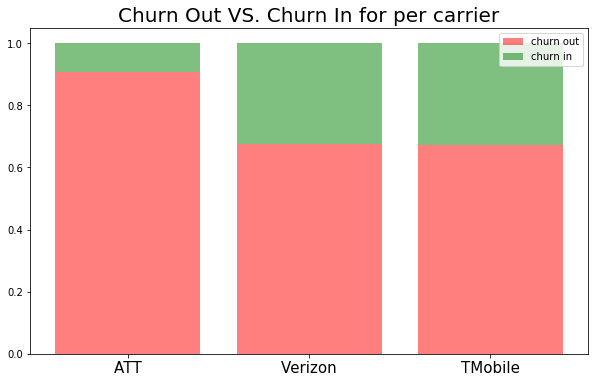

In [202]:
x_carrier = ['ATT','Verizon','TMobile']
churn_out_percent = []
churn_in_percent = []
churn_out_percent.append(att_move_out/(att_move_out+att_move_in))
churn_in_percent.append(att_move_in/(att_move_out+att_move_in))
churn_out_percent.append(ver_move_out/(ver_move_out+ver_move_in))
churn_in_percent.append(ver_move_in/(ver_move_out+ver_move_in))
churn_out_percent.append(tmo_move_out/(tmo_move_out+tmo_move_in))
churn_in_percent.append(tmo_move_in/(tmo_move_out+tmo_move_in))


plt.figure(figsize=(10,6))
p1 = plt.bar(x_carrier, churn_out_percent, color='r',label='churn out',alpha=0.5)
p2 = plt.bar(x_carrier, churn_in_percent, bottom=churn_out_percent, color='g', label='churn in',alpha=0.5)
plt.legend()
plt.xticks(fontsize=15)
plt.title('Churn Out VS. Churn In for per carrier', fontsize=20)
plt.show()

In [253]:
import numpy as np

def drawPlot(neg, pos, name, title):
    bar_width = 0.3
    x = np.arange(len(name))
    plt.figure(figsize=(20, 8))
    plt.bar(x+bar_width/2, neg, width=bar_width, label="Churn Out", color='r', alpha=0.5)
    plt.bar(x+bar_width*1.5, pos, width=bar_width, label="Churn In", color='g', alpha=0.5)
    
    plt.legend(loc=0,fontsize=15)
    plt.xticks(x+bar_width, name, fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(title, fontsize=20)
    plt.grid(alpha=0.2)
    plt.ylabel('percentage',fontsize=20)
    
#     x_text = list(x)+list(x+bar_width)
#     y_text = neg + pos
#     for a,b in zip(x_text,y_text):
#         plt.text(a, b, b, ha='center', va='bottom', fontsize=8)
    plt.show()

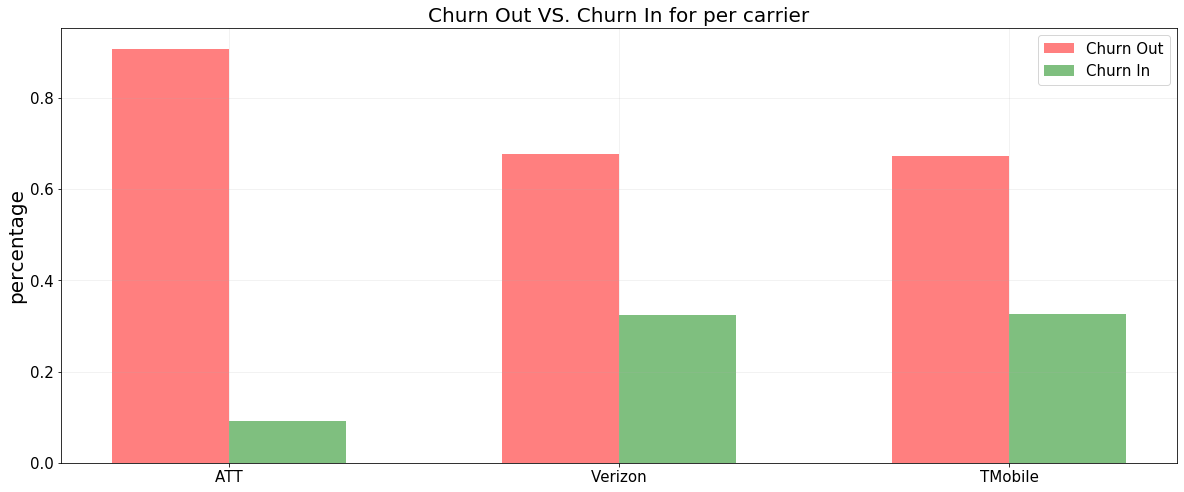

In [254]:
drawPlot(churn_out_percent, churn_in_percent, x_carrier, 'Churn Out VS. Churn In for per carrier')

In [163]:
att_move_reason_text = ' '.join(att_move_reason)
ver_move_reason_text = ' '.join(ver_move_reason)
tmo_move_reason_text = ' '.join(tmo_move_reason)

## Churn Reason Vocabulary

In [175]:
import nltk

# Corpus processing and cleanning
def cleanCorpusNLTK(corpus):
    # get words list
    words = nltk.tokenize.word_tokenize(corpus)
    # filter out non-alphabet value
    words = [w for w in words if w.isalpha()]
    # filter out the words that is less than 2 char, such as 'I'
    words = [w for w in words if len(w) > 2]
    # lower all alphabet 
    words = [w.lower() for w in words]
    # filter out 'amp'(&amp), 'u'(you), and 'http'
    words = [w for w in words if w not in ['amp', 'u', 'http', 'https', 'att', 'verizon', 'tmobile']]
    # filter out stopwords
    stop_words = nltk.corpus.stopwords.words('english')
    words = [w for w in words if w not in stop_words]
    # imporve linguistic ability in case of overstemming
    wordnet = nltk.stem.WordNetLemmatizer()
    lemmatized = [wordnet.lemmatize(w) for w in words]
    return lemmatized

In [176]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def drawWordCloud(corpus):
    text_corpus = ' '.join(cleanCorpusNLTK(att_move_reason_text))
    wordcloud = WordCloud(width=500, height=500, background_color='white', 
                min_font_size =12).generate(text_corpus)
    plt.imshow(wordcloud)

## Reasons 

Why people wants to churn from their original carrier?


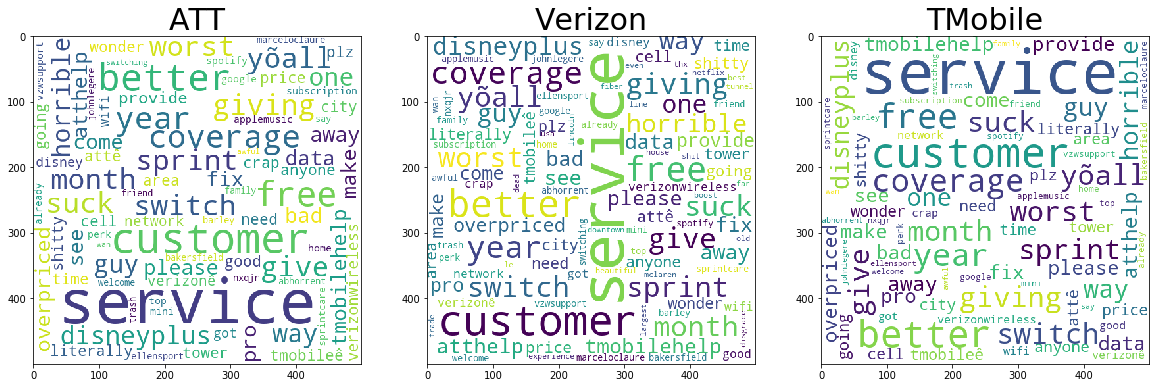

In [184]:
print('Why people wants to churn from their original carrier?')
plt.figure(figsize=(20,10))
plt.subplot(131)
drawWordCloud(att_move_reason_text)
plt.title('ATT', fontsize=30)
plt.subplot(132)
drawWordCloud(ver_move_reason_text)
plt.title('Verizon', fontsize=30)
plt.subplot(133)
drawWordCloud(tmo_move_reason_text)
plt.title('TMobile', fontsize=30)
plt.show()

## Suggestions

In [190]:
def readReasons(move_reason):
    for m in move_reason:
        print(m,'\n')

In [191]:
readReasons(att_move_reason)

@ATT so @verizon is giving away a free year of @disneyplus on top of their already free subscription to @AppleMusic... & @Spotify is giving away free @google home minis... where are our perks?!? 

@ATTHelp @verizon @VZWSupport @TMobile @TMobileHelp @sprintcare @sprint  @marceloclaure  all of you guys have the worst Data Service in Bakersfield CA I go see a friend on Ellensport Way 93313 all bad Data barley get 2mb please fix" 

All I can say is ATT is trash and Verizon is overpriced. 

@NXQJR @JohnLegere @TMobile @ATT Come on over welcome to the TMobile family 

Itâs abhorrent customer âservice.â 

Switching from the awful att...wanna make my experience even better and trade me my less than one month old 7 Pro for that beautiful McLaren 7T Pro? 

Having @ATT worst service for 11 months I switch to @verizon and have had the best service. 

ATT fiber and Verizon will not provide service to my house and it is literally in the downtown of the 10th largest city in USA. 

No service in

In [192]:
readReasons(ver_move_reason)

@verizon @VZWSupport how is your coverage at Houston (HOU)? 

@JohnLegere @piratesbooty @verizon I'd use TMobile but they have no coverage in my area 

@ATTHelp @verizon @VZWSupport @TMobile @TMobileHelp @sprintcare @sprint  @marceloclaure  all of you guys have the worst Data Service in Bakersfield CA I go see a friend on Ellensport Way 93313 all bad Data barley get 2mb please fix" 

All I can say is ATT is trash and Verizon is overpriced. 

We're with @TMobile now, best service where I'm 

@verizon literally has the worst customer service. 

ATT fiber and Verizon will not provide service to my house and it is literally in the downtown of the 10th largest city in USA. 

@JohnLegere - I use @verizon and I use a ton of data over LTE (+35GBs/month)... if I switched to @TMobile would I still be throttled when thereâs ânetwork congestion?â" 

Why tf dont i have service in romulus smh im finna go back to verizon tmobile so ass 

from what my dad told me but yeah im considering going to

In [193]:
readReasons(tmo_move_reason)

on the same note my dad switched his phone into my phone bill and he also had prepaid the following month for service. 

I'm just amazed at the stark customer service difference.â¦ https://t.co/XLYWZjuhQ4" 

@verizon got Disney Plus for one year free? 

@JohnLegere @piratesbooty @verizon I'd use TMobile but they have no coverage in my area 

@ATTHelp @verizon @VZWSupport @TMobile @TMobileHelp @sprintcare @sprint  @marceloclaure  all of you guys have the worst Data Service in Bakersfield CA I go see a friend on Ellensport Way 93313 all bad Data barley get 2mb please fix" 

Itâs abhorrent customer âservice.â 

Switching from the awful att...wanna make my experience even better and trade me my less than one month old 7 Pro for that beautiful McLaren 7T Pro? 

Why tf dont i have service in romulus smh im finna go back to verizon tmobile so ass 

@TMobile @TMobileHelp YOUR SERVICE IS ð©ð©ð© AF Iâm Going To @verizon 

No service in the Lincoln Tunnel with @ATT Wonder if I had 